In [244]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
%autoreload 2

In [246]:
from master import *
from models import *

In [247]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [248]:
import scipy

### Defining Parameters and Loading Trained Model

In [249]:
# !nvidia-smi

In [250]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = '/beegfs/bva212/fma_small_cqt/'
PATH_TO_AUDIO_FILES = '/beegfs/bva212/fma_small/'
PATH_FILE = 'checksums'
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TRANSFORM_PROB  = 0.5
SR = 22050
MODEL_LOAD_PATH = '/beegfs/sc6957/capstone/models/snet2_jigsaw_small_best_model.pth'
PREDS_SAVE_PATH = '/beegfs/sc6957/capstone/fma_small_valid_predictions.pkl'
LOAD_PREDS = False
MODE = 'jigsaw'
MODEL_ARCHITECTURE = 'snet2'  #['l3net','snet',snet2',anet']
SEPARABLE = False
REDUCE_TWO_CLASS = True #Applies to jigsaw (6-class to 2-class)
NUM_SECONDS=10

In [251]:
DEVICE

device(type='cuda', index=0)

In [252]:
start = time.time()
MODEL,MODEL_NAME = load_model(DEVICE, MODEL_ARCHITECTURE, MODE, SEPARABLE)
master = Master(DEVICE, ROOT_DIR, PATH_FILE, SR, BATCH_SIZE, VAL_SPLIT, TRANSFORM_PROB, REDUCE_TWO_CLASS, MODE, MODEL, NUM_SECONDS)
print(f'time for instantiating audio net object - {time.time() - start}')

Instantiating Model snet2_jigsaw
Number of Seconds: 10
MODE: jigsaw
Getting Train & Validation Datasets
Excluding these 3 files - ['098/098567.mp3_cqt.npy', '098/098565.mp3_cqt.npy', '098/098569.mp3_cqt.npy']
There are a total of 7836 music files in the root directory
TRANSFORMING DATA!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Training samples: 6268 	 # Validation samples: 1567
	 --Done
Creating Train & Validation Dataloaders
Length of Train dataloader: 196 	 Validation dataloader: 49
	 --Done
	 --Done
Init actions done
time for instantiating audio net object - 2.3335371017456055


In [253]:
model_save_dict = torch.load(MODEL_LOAD_PATH)
master.model.load_state_dict(model_save_dict['modelStateDict'])

<All keys matched successfully>

In [254]:
master.model

snet2_jigsaw(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(5, 5))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(5, 5))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (10): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

### Checking Validation Performance

In [255]:
start = time.time()
val_acc = master.evaluate_performance(compute_val = True)
print(f'time for computation - {time.time() - start}')

Phase: valid   Iteration 49/49
Performance computed on valid dataset over 1567 observations 
	Acc: 0.6669
time for computation - 4.503820419311523


### Getting predictions for Validation Data

In [256]:
LOAD_PREDS=True
if LOAD_PREDS:
    preds = pkl.load(open(PREDS_SAVE_PATH, "rb"))
else:
    start = time.time()
    preds = master.get_predictions(phase = 'valid', save = True, preds_save_path= PREDS_SAVE_PATH)
    print(f'time for fetching predictions - {time.time() - start}')

In [257]:
permutation_mappings = [
    ([0,1,2],[1,0,0,0,0,0],0),
    ([0,2,1],[0,1,0,0,0,0],1),
    ([1,0,2],[0,0,1,0,0,0],2),
    ([1,2,0],[0,0,0,1,0,0],3),
    ([2,0,1],[0,0,0,0,1,0],4),
    ([2,1,0],[0,0,0,0,0,1],5)
]

In [258]:
predictions_df = pd.DataFrame(preds, columns=['file_name', 
                                              'start_width',
                                              'chosen_perm',
                                              'y_true', 
                                              'logits', 
                                              'y_pred'])
predictions_df['probabilities'] = predictions_df.logits.apply(lambda x:scipy.special.softmax(x))
predictions_df['class_1_prob'] = predictions_df.probabilities.apply(lambda x:x[1])
predictions_df['perm_map'] = predictions_df.chosen_perm.apply(lambda x:permutation_mappings[x][0])
predictions_df.head()

file_name  start_width  chosen_perm  y_true  \
0  022/022472.mp3_cqt.npy          791            2       1   
1  075/075754.mp3_cqt.npy          352            0       0   
2  032/032437.mp3_cqt.npy           20            0       0   
3  079/079605.mp3_cqt.npy          503            0       0   
4  000/000718.mp3_cqt.npy          500            4       1   

                     logits  y_pred             probabilities  class_1_prob  \
0  [-4.2033114, -3.8733015]       1  [0.41823822, 0.58176184]      0.581762   
1  [-2.5287578, -2.6356244]       0  [0.52669126, 0.47330877]      0.473309   
2  [-4.4177566, 0.16678216]       1  [0.010105297, 0.9898947]      0.989895   
3   [-2.7714355, -2.488715]       1   [0.42978692, 0.5702131]      0.570213   
4  [-4.7843814, -2.4531364]       1  [0.088568114, 0.9114319]      0.911432   

    perm_map  
0  [1, 0, 2]  
1  [0, 1, 2]  
2  [0, 1, 2]  
3  [0, 1, 2]  
4  [2, 0, 1]

In [259]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
print(f'Validation AUC score is {roc_auc_score(predictions_df.y_true.values, predictions_df.class_1_prob.values):.4f}')
print(f'Validation Accuracy is {accuracy_score(predictions_df.y_true.values, predictions_df.y_pred.values):.4f}')

Validation AUC score is 0.6761
Validation Accuracy is 0.5967


### Correct Classified Examples Analysis

In [260]:
correct_preds = predictions_df[['file_name',
                                  'start_width',
                                'chosen_perm',
                                  'y_true', 
                                  'y_pred', 
                                  'class_1_prob',
                               'perm_map']][predictions_df.y_true == predictions_df.y_pred]

In [261]:
correct_jigsaw_with_hc = correct_preds.sort_values(by = ['y_pred', 'class_1_prob'], 
                                             axis = 0,
                                             ascending = [False, False])

In [262]:
correct_jigsaw_with_hc.head(10)

file_name  start_width  chosen_perm  y_true  y_pred  \
23   141/141180.mp3_cqt.npy          802            2       1       1   
56   115/115597.mp3_cqt.npy          352            2       1       1   
66   006/006461.mp3_cqt.npy          721            3       1       1   
74   000/000821.mp3_cqt.npy          499            2       1       1   
79   038/038365.mp3_cqt.npy          259            4       1       1   
152  113/113269.mp3_cqt.npy           94            3       1       1   
182  145/145758.mp3_cqt.npy          481            2       1       1   
220  064/064247.mp3_cqt.npy           54            2       1       1   
232  138/138061.mp3_cqt.npy          529            4       1       1   
246  069/069205.mp3_cqt.npy          404            1       1       1   

     class_1_prob   perm_map  
23            1.0  [1, 0, 2]  
56            1.0  [1, 0, 2]  
66            1.0  [1, 2, 0]  
74            1.0  [1, 0, 2]  
79            1.0  [2, 0, 1]  
152           1.0  [1, 2, 0]  
182           1.0  [1, 0, 2]  
220           1.0  [1, 0, 2]  
232           1.0  [2, 0, 1]  
246           1.0  [0, 2, 1]

In [263]:
correct_normal_with_hc = correct_preds.sort_values(by = ['y_pred', 'class_1_prob'], 
                                                 axis = 0,
                                                 ascending = [True, True])
correct_normal_with_hc.head(10)

file_name  start_width  chosen_perm  y_true  y_pred  \
664  120/120299.mp3_cqt.npy          728            0       0       0   
302  072/072072.mp3_cqt.npy          593            0       0       0   
354  040/040598.mp3_cqt.npy          573            0       0       0   
72   114/114238.mp3_cqt.npy           16            0       0       0   
631  012/012691.mp3_cqt.npy          814            0       0       0   
615  026/026651.mp3_cqt.npy          586            0       0       0   
763  112/112781.mp3_cqt.npy          731            0       0       0   
936  144/144471.mp3_cqt.npy           18            0       0       0   
103  133/133942.mp3_cqt.npy          423            0       0       0   
105  153/153337.mp3_cqt.npy            3            0       0       0   

     class_1_prob   perm_map  
664  6.438208e-17  [0, 1, 2]  
302  2.675895e-10  [0, 1, 2]  
354  1.685671e-07  [0, 1, 2]  
72   1.995652e-07  [0, 1, 2]  
631  8.806866e-07  [0, 1, 2]  
615  1.145563e-06  [0, 1, 2]  
763  2.599480e-06  [0, 1, 2]  
936  5.044451e-06  [0, 1, 2]  
103  5.683920e-06  [0, 1, 2]  
105  7.109896e-06  [0, 1, 2]

### Visualizing Correct Classified Examples

#### Examples which are jigsawed. Correctly classified with high confidence

For all the below examples true label is 1 (jigsaw)  and the model predicts them as 1 (jigsaw) with high confidence

----------------------------------------------------------------------------------------------------
141/141180.mp3_cqt.npy    start second is 18.80    confidence is 1.0000


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Original


Jigsaw
Permutation: [1, 0, 2]
802
Complete Jigsaw Piece


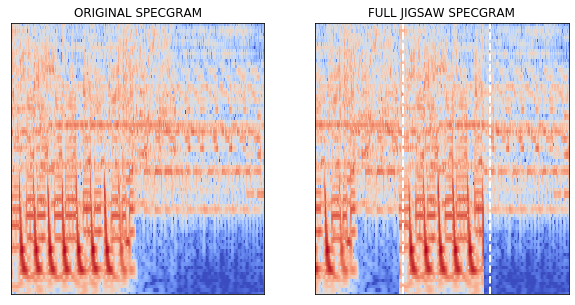

interactive(children=(Dropdown(description='i', options=(0, 1, 2), value=0), Output()), _dom_classes=('widget-…

In [264]:
print('For all the below examples true label is 1 (jigsaw)  and the model predicts them as 1 (jigsaw) with high confidence\n')
num_examples_to_show = 10
for i in range(1):
    print('-'*100)
    print(f"{correct_jigsaw_with_hc['file_name'].iloc[i]}\
    start second is {correct_jigsaw_with_hc['start_width'].iloc[i]/1280 * 30:.2f}\
    confidence is {correct_jigsaw_with_hc['class_1_prob'].iloc[i]:.4f}")
          
    start_width = correct_jigsaw_with_hc['start_width'].iloc[i]
    perm_map = correct_jigsaw_with_hc['perm_map'].iloc[i]
    waveform, _ = librosa.load(PATH_TO_AUDIO_FILES + correct_jigsaw_with_hc['file_name'].iloc[i][:-8], sr = SR)
    obj = ipd.Audio(waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)], rate=SR)
    print()
    print('Original')
    ipd.display(obj)
    print('Jigsaw')
    print(f'Permutation: {perm_map}')
    chosen_split = waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)]
    print(start_width)
#     print(int(start_width*30/1280*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR) - int(start_width*30/1280*SR) +1)
#     print(chosen_split.shape)
    jigsaw_splits = [np.split(chosen_split, 3)][0]
    waveform_jigsaws = np.array([jigsaw_splits[x] for x in perm_map])

    print('Complete Jigsaw Piece')      
    waveform_jigsaw = np.concatenate(waveform_jigsaws)
#     print(waveform_jigsaw.shape)
    waveform_jigsaw = np.ascontiguousarray(waveform_jigsaw, dtype=np.float32)
    jigsaw_obj = ipd.Audio(waveform_jigsaw, rate=SR)
    ipd.display(jigsaw_obj)
    master.visualize_cqts(correct_jigsaw_with_hc['file_name'].iloc[i], 
                           start_width = start_width, perm_map=perm_map, display= True, figsize=(10,5))
          
    @interact
    def return_piece(i=range(3)):
          #for i,piece in enumerate(waveform_jigsaws):
          print(f'Position in Jigsaw {i}\nPosition in Original {perm_map[i]}')
          waveform_piece = np.ascontiguousarray(waveform_jigsaws[i], dtype=np.float32)
          waveform_piece_obj = ipd.Audio(waveform_piece, rate=SR)
          ipd.display(waveform_piece_obj)

#### Examples which are not jigsawed. Correctly classified with high confidence

For all the below examples true label is 0 (not jigsawed) and the model predicts them as not jigsawed with high confidence

----------------------------------------------------------------------------------------------------
120/120299.mp3_cqt.npy    start second is 17.06    confidence is 0.0000


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Original


Jigsaw
Permutation: [0, 1, 2]
728
Complete Jigsaw Piece


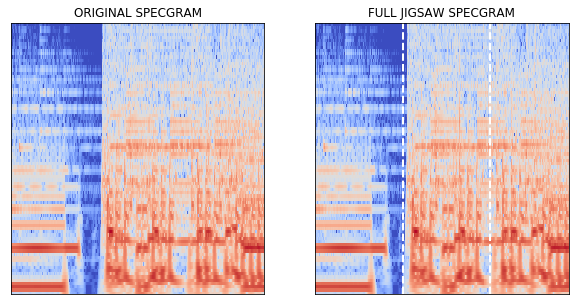

interactive(children=(Dropdown(description='i', options=(0, 1, 2), value=0), Output()), _dom_classes=('widget-…

In [270]:
print('For all the below examples true label is 0 (not jigsawed) and the model predicts them as not jigsawed with high confidence\n')
num_examples_to_show = 10
for i in range(1):
    print('-'*100)
    print(f"{correct_normal_with_hc['file_name'].iloc[i]}\
    start second is {correct_normal_with_hc['start_width'].iloc[i]/1280 * 30:.2f}\
    confidence is {correct_normal_with_hc['class_1_prob'].iloc[i]:.4f}")
          
    start_width = correct_normal_with_hc['start_width'].iloc[i]
    perm_map = correct_normal_with_hc['perm_map'].iloc[i]
    waveform, _ = librosa.load(PATH_TO_AUDIO_FILES + correct_normal_with_hc['file_name'].iloc[i][:-8], sr = SR)
    obj = ipd.Audio(waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)], rate=SR)
    print()
    print('Original')
    ipd.display(obj)
    print('Jigsaw')
    print(f'Permutation: {perm_map}')
    chosen_split = waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)]
    print(start_width)
#     print(int(start_width*30/1280*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR) - int(start_width*30/1280*SR) +1)
#     print(chosen_split.shape)
    jigsaw_splits = [np.split(chosen_split, 3)][0]
    waveform_jigsaws = np.array([jigsaw_splits[x] for x in perm_map])

    print('Complete Jigsaw Piece')      
    waveform_jigsaw = np.concatenate(waveform_jigsaws)
#     print(waveform_jigsaw.shape)
    waveform_jigsaw = np.ascontiguousarray(waveform_jigsaw, dtype=np.float32)
    jigsaw_obj = ipd.Audio(waveform_jigsaw, rate=SR)
    ipd.display(jigsaw_obj)
    master.visualize_cqts(correct_normal_with_hc['file_name'].iloc[i], 
                           start_width = start_width, perm_map=perm_map, display= True, figsize=(10,5))
          
    @interact
    def return_piece(i=range(3)):
          #for i,piece in enumerate(waveform_jigsaws):
          print(f'Position in Jigsaw {i}\nPosition in Original {perm_map[i]}')
          waveform_piece = np.ascontiguousarray(waveform_jigsaws[i], dtype=np.float32)
          waveform_piece_obj = ipd.Audio(waveform_piece, rate=SR)
          ipd.display(waveform_piece_obj)

### Incorrect Classified Examples Analysis

In [266]:
incorrect_preds = predictions_df[['file_name',
                                  'start_width',
                                  'chosen_perm',
                                  'y_true', 
                                  'y_pred', 
                                  'class_1_prob',
                                 'perm_map']][predictions_df.y_true != predictions_df.y_pred]

#### Incorrectly classified not jigsaw as jigsaw classified with high confidence

In [268]:
incorr_not_jigsaw_with_hc = incorrect_preds.sort_values(by = ['y_pred', 'class_1_prob'], 
                                                 axis = 0,
                                                 ascending = [False, False])
incorr_not_jigsaw_with_hc.head(10)

file_name  start_width  chosen_perm  y_true  y_pred  \
198   086/086725.mp3_cqt.npy          765            0       0       1   
413   122/122810.mp3_cqt.npy          715            0       0       1   
582   141/141282.mp3_cqt.npy          326            0       0       1   
816   100/100497.mp3_cqt.npy          126            0       0       1   
992   078/078038.mp3_cqt.npy          203            0       0       1   
1191  116/116407.mp3_cqt.npy          431            0       0       1   
1291  059/059679.mp3_cqt.npy          718            0       0       1   
1125  126/126520.mp3_cqt.npy          551            0       0       1   
606   046/046928.mp3_cqt.npy          467            0       0       1   
378   045/045127.mp3_cqt.npy          601            0       0       1   

      class_1_prob   perm_map  
198       1.000000  [0, 1, 2]  
413       1.000000  [0, 1, 2]  
582       1.000000  [0, 1, 2]  
816       1.000000  [0, 1, 2]  
992       1.000000  [0, 1, 2]  
1191      1.000000  [0, 1, 2]  
1291      1.000000  [0, 1, 2]  
1125      1.000000  [0, 1, 2]  
606       1.000000  [0, 1, 2]  
378       0.999999  [0, 1, 2]

#### Incorrectly classified jigsaw as not jigsaw classified with high confidence

In [269]:
incorr_jigsaw_with_hc = incorrect_preds.sort_values(by = ['y_pred', 'class_1_prob'], 
                                                 axis = 0,
                                                 ascending = [True, True])
incorr_jigsaw_with_hc.head(10)

file_name  start_width  chosen_perm  y_true  y_pred  \
857   064/064553.mp3_cqt.npy          292            1       1       0   
1507  114/114282.mp3_cqt.npy           78            3       1       0   
799   050/050283.mp3_cqt.npy          865            3       1       0   
307   075/075374.mp3_cqt.npy          133            4       1       0   
981   003/003777.mp3_cqt.npy          485            4       1       0   
76    052/052446.mp3_cqt.npy          609            3       1       0   
522   144/144933.mp3_cqt.npy          446            1       1       0   
1403  124/124752.mp3_cqt.npy          332            3       1       0   
690   126/126241.mp3_cqt.npy          541            4       1       0   
656   088/088870.mp3_cqt.npy          328            1       1       0   

      class_1_prob   perm_map  
857       0.000024  [0, 2, 1]  
1507      0.000033  [1, 2, 0]  
799       0.000189  [1, 2, 0]  
307       0.000692  [2, 0, 1]  
981       0.003062  [2, 0, 1]  
76        0.003732  [1, 2, 0]  
522       0.009626  [0, 2, 1]  
1403      0.010995  [1, 2, 0]  
690       0.036875  [2, 0, 1]  
656       0.050450  [0, 2, 1]

### Visualizing Incorrect Classified Examples

#### Examples which are not jigsawed. Incorrectly classified with high confidence

For all the below examples true label is 0 (not jigsawed) and the model predicts them as jigsawed (1) with high confidence

----------------------------------------------------------------------------------------------------
086/086725.mp3_cqt.npy    start second is 17.93    confidence is 1.0000


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Original


Jigsaw
Permutation: [0, 1, 2]
765
Complete Jigsaw Piece


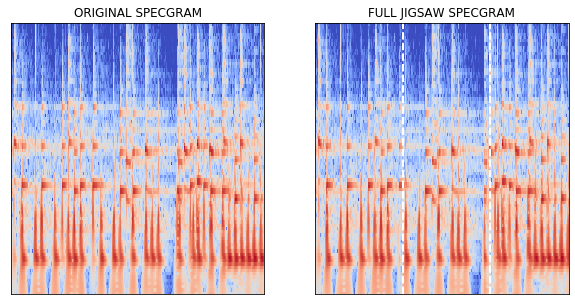

interactive(children=(Dropdown(description='i', options=(0, 1, 2), value=0), Output()), _dom_classes=('widget-…

In [271]:
print('For all the below examples true label is 0 (not jigsawed) and the model predicts them as jigsawed (1) with high confidence\n')
num_examples_to_show = 10
for i in range(1):
    print('-'*100)
    print(f"{incorr_not_jigsaw_with_hc['file_name'].iloc[i]}\
    start second is {incorr_not_jigsaw_with_hc['start_width'].iloc[i]/1280 * 30:.2f}\
    confidence is {incorr_not_jigsaw_with_hc['class_1_prob'].iloc[i]:.4f}")
          
    start_width = incorr_not_jigsaw_with_hc['start_width'].iloc[i]
    perm_map = incorr_not_jigsaw_with_hc['perm_map'].iloc[i]
    waveform, _ = librosa.load(PATH_TO_AUDIO_FILES + incorr_not_jigsaw_with_hc['file_name'].iloc[i][:-8], sr = SR)
    obj = ipd.Audio(waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)], rate=SR)
    print()
    print('Original')
    ipd.display(obj)
    print('Jigsaw')
    print(f'Permutation: {perm_map}')
    chosen_split = waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)]
    print(start_width)
#     print(int(start_width*30/1280*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR) - int(start_width*30/1280*SR) +1)
#     print(chosen_split.shape)
    jigsaw_splits = [np.split(chosen_split, 3)][0]
    waveform_jigsaws = np.array([jigsaw_splits[x] for x in perm_map])

    print('Complete Jigsaw Piece')      
    waveform_jigsaw = np.concatenate(waveform_jigsaws)
#     print(waveform_jigsaw.shape)
    waveform_jigsaw = np.ascontiguousarray(waveform_jigsaw, dtype=np.float32)
    jigsaw_obj = ipd.Audio(waveform_jigsaw, rate=SR)
    ipd.display(jigsaw_obj)
    master.visualize_cqts(incorr_not_jigsaw_with_hc['file_name'].iloc[i], 
                           start_width = start_width, perm_map=perm_map, display= True, figsize=(10,5))
          
    @interact
    def return_piece(i=range(3)):
          #for i,piece in enumerate(waveform_jigsaws):
          print(f'Position in Jigsaw {i}\nPosition in Original {perm_map[i]}')
          waveform_piece = np.ascontiguousarray(waveform_jigsaws[i], dtype=np.float32)
          waveform_piece_obj = ipd.Audio(waveform_piece, rate=SR)
          ipd.display(waveform_piece_obj)

#### Examples which are jigsawed. Incorrectly classified with high confidence

For all the below examples true label is 1 ( jigsawed) and the model predicts them as not jigsawed (0) with high confidence

----------------------------------------------------------------------------------------------------
064/064553.mp3_cqt.npy    start second is 6.84    confidence is 0.0000


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Original


Jigsaw
Permutation: [0, 2, 1]
292
Complete Jigsaw Piece


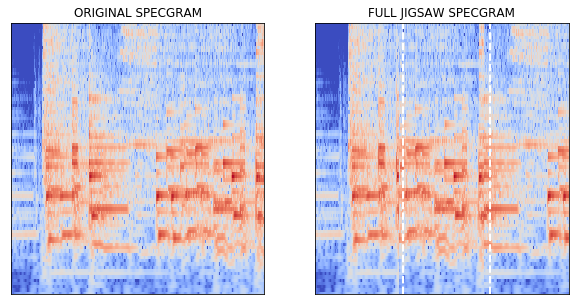

interactive(children=(Dropdown(description='i', options=(0, 1, 2), value=0), Output()), _dom_classes=('widget-…

In [273]:
print('For all the below examples true label is 1 ( jigsawed) and the model predicts them as not jigsawed (0) with high confidence\n')
num_examples_to_show = 10
for i in range(1):
    print('-'*100)
    print(f"{incorr_jigsaw_with_hc['file_name'].iloc[i]}\
    start second is {incorr_jigsaw_with_hc['start_width'].iloc[i]/1280 * 30:.2f}\
    confidence is {incorr_jigsaw_with_hc['class_1_prob'].iloc[i]:.4f}")
          
    start_width = incorr_jigsaw_with_hc['start_width'].iloc[i]
    perm_map = incorr_jigsaw_with_hc['perm_map'].iloc[i]
    waveform, _ = librosa.load(PATH_TO_AUDIO_FILES + incorr_jigsaw_with_hc['file_name'].iloc[i][:-8], sr = SR)
    obj = ipd.Audio(waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)], rate=SR)
    print()
    print('Original')
    ipd.display(obj)
    print('Jigsaw')
    print(f'Permutation: {perm_map}')
    chosen_split = waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)]
    print(start_width)
#     print(int(start_width*30/1280*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR) - int(start_width*30/1280*SR) +1)
#     print(chosen_split.shape)
    jigsaw_splits = [np.split(chosen_split, 3)][0]
    waveform_jigsaws = np.array([jigsaw_splits[x] for x in perm_map])

    print('Complete Jigsaw Piece')      
    waveform_jigsaw = np.concatenate(waveform_jigsaws)
#     print(waveform_jigsaw.shape)
    waveform_jigsaw = np.ascontiguousarray(waveform_jigsaw, dtype=np.float32)
    jigsaw_obj = ipd.Audio(waveform_jigsaw, rate=SR)
    ipd.display(jigsaw_obj)
    master.visualize_cqts(incorr_jigsaw_with_hc['file_name'].iloc[i], 
                           start_width = start_width, perm_map=perm_map, display= True, figsize=(10,5))
          
    @interact
    def return_piece(i=range(3)):
          #for i,piece in enumerate(waveform_jigsaws):
          print(f'Position in Jigsaw {i}\nPosition in Original {perm_map[i]}')
          waveform_piece = np.ascontiguousarray(waveform_jigsaws[i], dtype=np.float32)
          waveform_piece_obj = ipd.Audio(waveform_piece, rate=SR)
          ipd.display(waveform_piece_obj)

### Most Confusingly Classified Examples

In [275]:
confusing_preds = predictions_df[['file_name',
                                  'start_width',
                                  'chosen_perm',
                                  'y_true', 
                                  'y_pred', 
                                  'class_1_prob',
                                 'perm_map']]

In [276]:
confusing_preds['distance_from_0.5'] = np.abs(confusing_preds['class_1_prob'] - 0.5)

/home/sc6957/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [277]:
confusing = confusing_preds.sort_values(by = 'distance_from_0.5', ascending = True)
confusing.head(10)

file_name  start_width  chosen_perm  y_true  y_pred  \
961   053/053152.mp3_cqt.npy          100            1       1       1   
351   148/148218.mp3_cqt.npy          458            0       0       1   
1301  110/110778.mp3_cqt.npy          461            0       0       0   
137   047/047526.mp3_cqt.npy          118            0       0       1   
725   019/019729.mp3_cqt.npy          160            0       0       0   
1532  149/149416.mp3_cqt.npy          603            0       0       0   
266   000/000459.mp3_cqt.npy          856            1       1       1   
874   049/049441.mp3_cqt.npy          378            4       1       1   
1346  010/010575.mp3_cqt.npy          657            3       1       1   
1388  131/131796.mp3_cqt.npy          506            0       0       0   

      class_1_prob   perm_map  distance_from_0.5  
961       0.500459  [0, 2, 1]           0.000459  
351       0.500831  [0, 1, 2]           0.000831  
1301      0.498910  [0, 1, 2]           0.001090  
137       0.501580  [0, 1, 2]           0.001580  
725       0.498198  [0, 1, 2]           0.001802  
1532      0.497412  [0, 1, 2]           0.002588  
266       0.502970  [0, 2, 1]           0.002970  
874       0.503006  [2, 0, 1]           0.003006  
1346      0.503207  [1, 2, 0]           0.003207  
1388      0.496706  [0, 1, 2]           0.003294

### Visualizing Most Confusing Classified Examples

For all the below examples model is most confused

----------------------------------------------------------------------------------------------------
053/053152.mp3_cqt.npy    start second is 2.34    confidence is 0.5005


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Original


Jigsaw
Permutation: [0, 2, 1]
100
Complete Jigsaw Piece


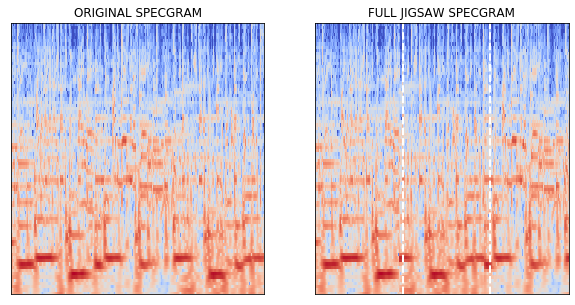

interactive(children=(Dropdown(description='i', options=(0, 1, 2), value=0), Output()), _dom_classes=('widget-…

In [278]:
print('For all the below examples model is most confused\n')
num_examples_to_show = 10
for i in range(1):
    print('-'*100)
    print(f"{confusing['file_name'].iloc[i]}\
    start second is {confusing['start_width'].iloc[i]/1280 * 30:.2f}\
    confidence is {confusing['class_1_prob'].iloc[i]:.4f}")
          
    start_width = confusing['start_width'].iloc[i]
    perm_map = confusing['perm_map'].iloc[i]
    waveform, _ = librosa.load(PATH_TO_AUDIO_FILES + confusing['file_name'].iloc[i][:-8], sr = SR)
    obj = ipd.Audio(waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)], rate=SR)
    print()
    print('Original')
    ipd.display(obj)
    print('Jigsaw')
    print(f'Permutation: {perm_map}')
    chosen_split = waveform[int(start_width*30/1280*SR):int((NUM_SECONDS + start_width*30/1280)*SR)]
    print(start_width)
#     print(int(start_width*30/1280*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR))
#     print(int((NUM_SECONDS + start_width*30/1280)*SR) - int(start_width*30/1280*SR) +1)
#     print(chosen_split.shape)
    jigsaw_splits = [np.split(chosen_split, 3)][0]
    waveform_jigsaws = np.array([jigsaw_splits[x] for x in perm_map])

    print('Complete Jigsaw Piece')      
    waveform_jigsaw = np.concatenate(waveform_jigsaws)
#     print(waveform_jigsaw.shape)
    waveform_jigsaw = np.ascontiguousarray(waveform_jigsaw, dtype=np.float32)
    jigsaw_obj = ipd.Audio(waveform_jigsaw, rate=SR)
    ipd.display(jigsaw_obj)
    master.visualize_cqts(confusing['file_name'].iloc[i], 
                           start_width = start_width, perm_map=perm_map, display= True, figsize=(10,5))
          
    @interact
    def return_piece(i=range(3)):
          #for i,piece in enumerate(waveform_jigsaws):
          print(f'Position in Jigsaw {i}\nPosition in Original {perm_map[i]}')
          waveform_piece = np.ascontiguousarray(waveform_jigsaws[i], dtype=np.float32)
          waveform_piece_obj = ipd.Audio(waveform_piece, rate=SR)
          ipd.display(waveform_piece_obj)